In [367]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from collections import Counter

In [368]:
anno_path = "../data/Anno_coarse"
eval_path = "../data/Eval"


bbox_path = os.path.join(anno_path, "list_bbox.txt")
landmarks_path = os.path.join(anno_path,"list_landmarks.txt")
category_cloth_path = os.path.join(anno_path, "list_category_cloth.txt")
category_img_path = os.path.join(anno_path, "list_category_img.txt")
attr_cloth_path = os.path.join(anno_path, "list_attr_cloth.txt")
attr_img_path = os.path.join(anno_path, "list_attr_img.txt")
eval_partition_path = os.path.join(eval_path, "list_eval_partition.txt")
img_folder = "../data/img"

# 1. Dataset EDA

In [369]:
"""
All data extraction information gathered from README.txt file provided in original dataset
"""

def load_bbox_annotations(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Skips header (first 2 lines)
    num_images = int(lines[0].strip())
    columns = lines[1].strip().split()

    data = []
    for i in range(2, len(lines)):
        line = lines[i].strip().split()
        img_name = line[0]

        for j in range(1, len(line) - 4):
            img_name += ' ' + line[j]
        
        # Bounding box coordinates in last 4 elements
        bbox = [int(x) for x in line[-4:]]
        data.append([img_name] + bbox)
    
    bbox_df = pd.DataFrame(data, columns=['image_name', 'x_1', 'y_1', 'x_2', 'y_2'])
    bbox_df['width'] = bbox_df['x_2'] - bbox_df['x_1']
    bbox_df['height'] = bbox_df['y_2'] - bbox_df['y_1']
    bbox_df['area'] = bbox_df['width'] * bbox_df['height']
    return bbox_df

def load_category_cloth(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    num_categories = int(lines[0].strip())
    columns = lines[1].strip().split()
    
    data = []
    for i in range(2, len(lines)):
        line = lines[i].strip().split()
        category_name = line[0]
        # Consider image path whitespace
        for j in range(1, len(line) - 1):
            category_name += ' ' + line[j]
        
        category_type = int(line[-1])
        data.append([i-1, category_name, category_type])
    
    category_df = pd.DataFrame(data, columns=['category_id', 'category_name', 'category_type'])
    category_df['category_type_name'] = category_df['category_type'].map({
        1: 'upper-body', 
        2: 'lower-body', 
        3: 'full-body'
    })
    return category_df

def load_category_img(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    num_images = int(lines[0].strip())
    columns = lines[1].strip().split()
    
    data = []
    for i in range(2, len(lines)):
        line = lines[i].strip().split()
        img_name = line[0]
        # Consider image path whitespace
        for j in range(1, len(line) - 1):
            img_name += ' ' + line[j]
        
        category_label = int(line[-1])
        data.append([img_name, category_label])
    
    img_category_df = pd.DataFrame(data, columns=['image_name', 'category_id'])
    return img_category_df

def load_eval_partition(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    num_images = int(lines[0].strip())
    columns = lines[1].strip().split()
    
    data = []
    for i in range(2, len(lines)):
        line = lines[i].strip().split()
        img_name = line[0]
        # Consider image path whitespace
        for j in range(1, len(line) - 1):
            img_name += ' ' + line[j]
        
        eval_status = line[-1]
        data.append([img_name, eval_status])
    
    eval_df = pd.DataFrame(data, columns=['image_name', 'eval_status'])
    return eval_df

def load_attributes_cloth(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    num_attributes = int(lines[0].strip())
    columns = lines[1].strip().split()
    
    data = []
    for i in range(2, len(lines)):
        line = lines[i].strip()
        parts = line.split()
        
        attr_type = int(parts[-1])
        attr_name = ' '.join(parts[:-1])
        
        attr_id = i - 2
        
        data.append([attr_id, attr_name, attr_type])
    
    attr_df = pd.DataFrame(data, columns=['attr_id', 'attr_name', 'attr_type'])
    attr_df['attr_type_name'] = attr_df['attr_type'].map({
        1: 'texture', 
        2: 'fabric', 
        3: 'shape', 
        4: 'part', 
        5: 'style'
    })
    
    return attr_df

def load_attributes_img(file_path, attr_df):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    num_images = int(lines[0].strip())
    num_attributes = len(attr_df)
    
    data = []
    
    for i in range(2, len(lines)):
        line = lines[i].strip()
        parts = line.split()
        
        # last 'num_attributes' are the attribute labels
        attr_labels = parts[-num_attributes:]
        
        attr_labels = [int(label) for label in attr_labels]
        
        img_name = ' '.join(parts[:-num_attributes])
        
        # Find positive attributes (val = 1)
        positive_attrs = [attr_id for attr_id, label in enumerate(attr_labels) if label == 1]
        
        data.append([img_name, positive_attrs])
    
    attr_img_df = pd.DataFrame(data, columns=['image_name', 'positive_attributes'])
    return attr_img_df

In [370]:
# Load category definitions
category_df = load_category_cloth(category_cloth_path)
print(f"Number of clothing categories: {len(category_df)}")
    
display(category_df.head())

Number of clothing categories: 50


,category_id,category_name,category_type,category_type_name
0,1,Anorak,1,upper-body
1,2,Blazer,1,upper-body
2,3,Blouse,1,upper-body
3,4,Bomber,1,upper-body
4,5,Button-Down,1,upper-body


In [371]:
# load bounding box annotations
bbox_df = load_bbox_annotations(bbox_path)
print(f"\nBounding box annotations count: {len(bbox_df)}")

display(bbox_df.head())


Bounding box annotations count: 289222


,image_name,x_1,y_1,x_2,y_2,width,height,area
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273,160,194,31040
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161,88,102,8976
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200,91,135,12285
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182,116,120,13920
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262,120,174,20880


In [372]:
# Load image category mappings
img_category_df = load_category_img(category_img_path)
print(f"\nImage-category mappings count: {len(img_category_df)}")

display(img_category_df.head())


Image-category mappings count: 289222


,image_name,category_id
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3


In [373]:
# Load evaluation partition
eval_df = load_eval_partition(eval_partition_path)
print(f"\nEvaluation partition entries: {len(eval_df)}")
    
display(eval_df.head())


Evaluation partition entries: 289222


,image_name,eval_status
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test


In [374]:
partition_counts = eval_df['eval_status'].value_counts()
    
# Calculate percentages
partition_percentages = partition_counts / partition_counts.sum() * 100
    
partition_stats = pd.DataFrame({
    'Count': partition_counts,
    'Percentage (%)': partition_percentages.round(2)
})
    
display(partition_stats)

,Count,Percentage (%)
eval_status,,
train,209222,72.34
val,40000,13.83
test,40000,13.83


In [375]:
img_with_category = pd.merge(img_category_df, category_df, on='category_id')
    
# Category distribution
category_counts = img_with_category['category_name'].value_counts()
    
print(f"{len(category_counts)} total clothing categories.")
print(f"Top 15 most common clothing categories:")
display(category_counts.head(15))

46 total clothing categories.
Top 15 most common clothing categories:


category_name
Dress       72158
Tee         36887
Blouse      24557
Shorts      19666
Tank        15429
Skirt       14773
Cardigan    13311
Sweater     13123
Jacket      10467
Top         10078
Blazer       7495
Romper       7408
Jeans        7076
Jumpsuit     6153
Leggings     5013
Name: count, dtype: int64

In [376]:
# load attribute definitions
attr_df = load_attributes_cloth(attr_cloth_path)
print(f"\nNumber of clothing attributes: {len(attr_df)}")
    
display(attr_df.head())


Number of clothing attributes: 1000


,attr_id,attr_name,attr_type,attr_type_name
0,0,a-line,3,shape
1,1,abstract,1,texture
2,2,abstract chevron,1,texture
3,3,abstract chevron print,1,texture
4,4,abstract diamond,1,texture


In [377]:
# load image attribute annotations
attr_img_df = load_attributes_img(attr_img_path, attr_df)
print(f"\nNumber of image attribute annotations: {len(attr_img_df)}")
    
display(attr_img_df.head())


Number of image attribute annotations: 289222


,image_name,positive_attributes
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,"[717, 818]"
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,"[717, 818]"
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,"[141, 717, 837, 956]"
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,[716]
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,"[349, 405, 717, 810]"


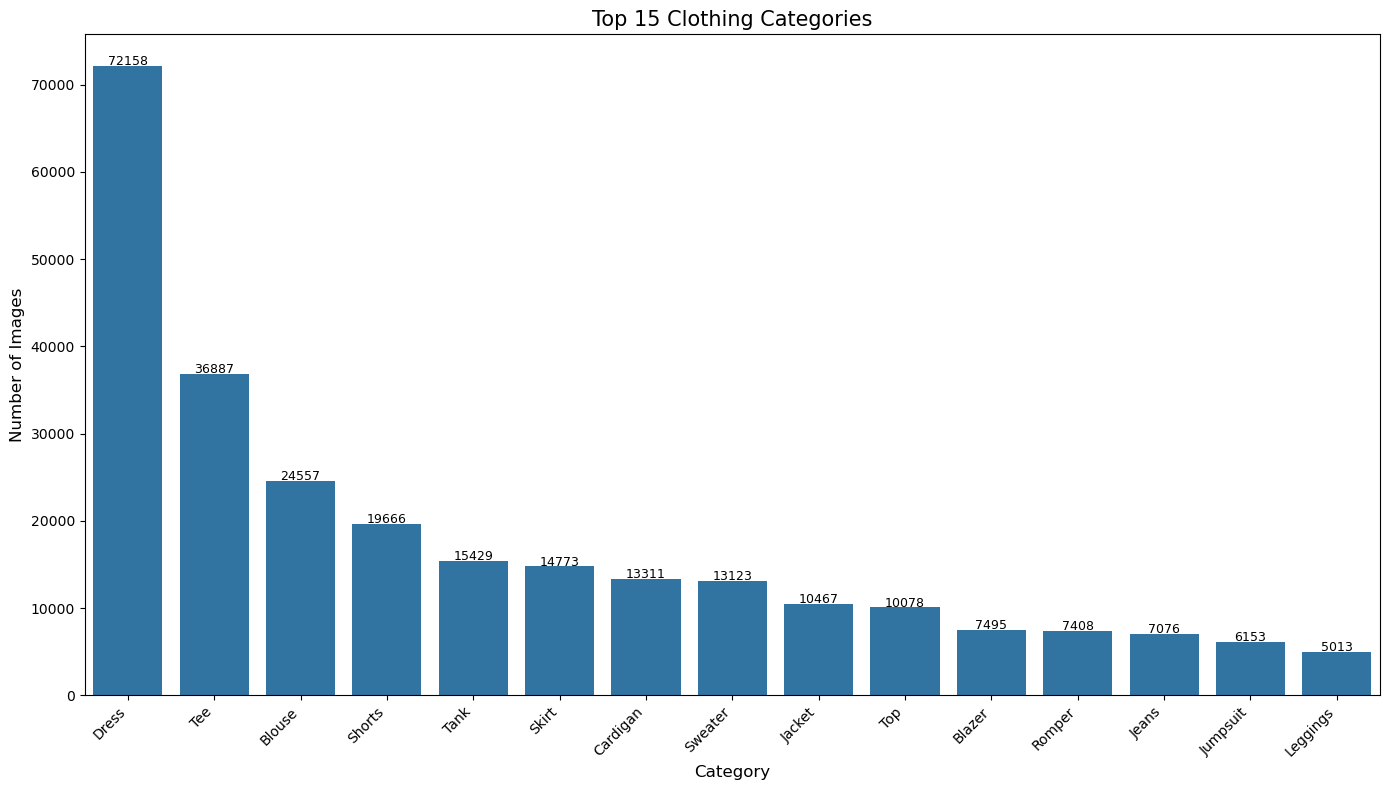

In [378]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=category_counts.head(15).index, y=category_counts.head(15).values)
plt.title('Top 15 Clothing Categories', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(category_counts.head(15)):
    ax.text(i, v + 100, f"{v}", ha='center', fontsize=9)
    
plt.tight_layout()
plt.show()

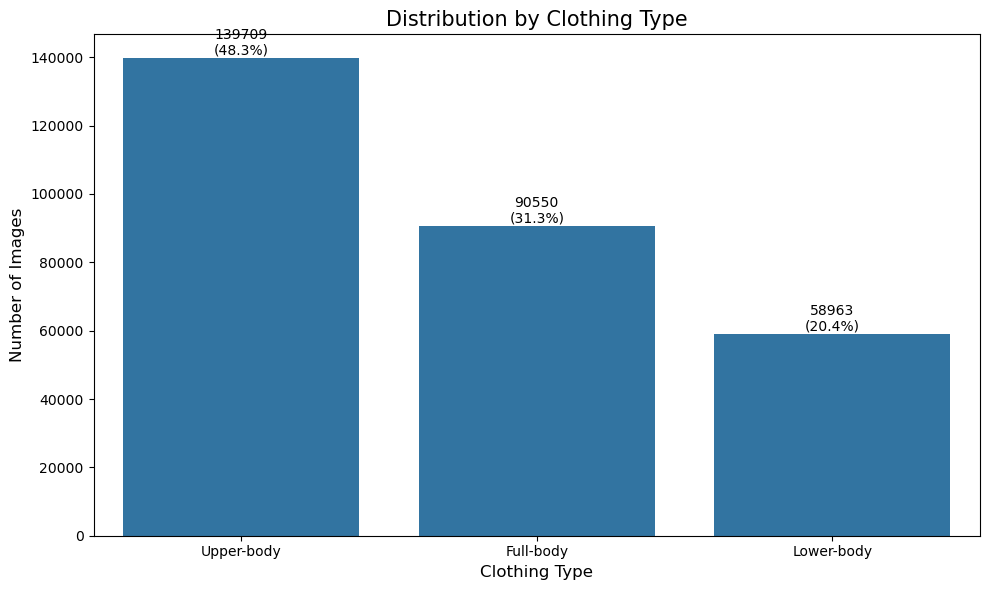

In [379]:
# Distribution by category type
type_mapping = {1: 'Upper-body', 2: 'Lower-body', 3: 'Full-body'}
category_type_counts = img_with_category['category_type'].map(type_mapping).value_counts()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=category_type_counts.index, y=category_type_counts.values)
plt.title('Distribution by Clothing Type', fontsize=15)
plt.xlabel('Clothing Type', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Percentage labels
total = category_type_counts.sum()
for i, v in enumerate(category_type_counts):
    percentage = (v / total) * 100
    ax.text(i, v + 1000, f"{v}\n({percentage:.1f}%)", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [380]:
# Width and height of bounding boxes
bbox_df['width'] = bbox_df['x_2'] - bbox_df['x_1']
bbox_df['height'] = bbox_df['y_2'] - bbox_df['y_1']
bbox_df['area'] = bbox_df['width'] * bbox_df['height']

print("Bounding box statistics:")
display(bbox_df[['width', 'height', 'area']].describe())

Bounding box statistics:


,width,height,area
count,289222.000000,289222.000000,289222.000000
mean,141.636964,195.795652,29261.880303
std,58.024783,63.176140,18008.464918
min,2.000000,6.000000,154.000000
25%,99.000000,151.000000,15738.000000
50%,134.000000,198.000000,26106.000000
75%,173.000000,245.000000,37800.000000
max,299.000000,299.000000,89401.000000


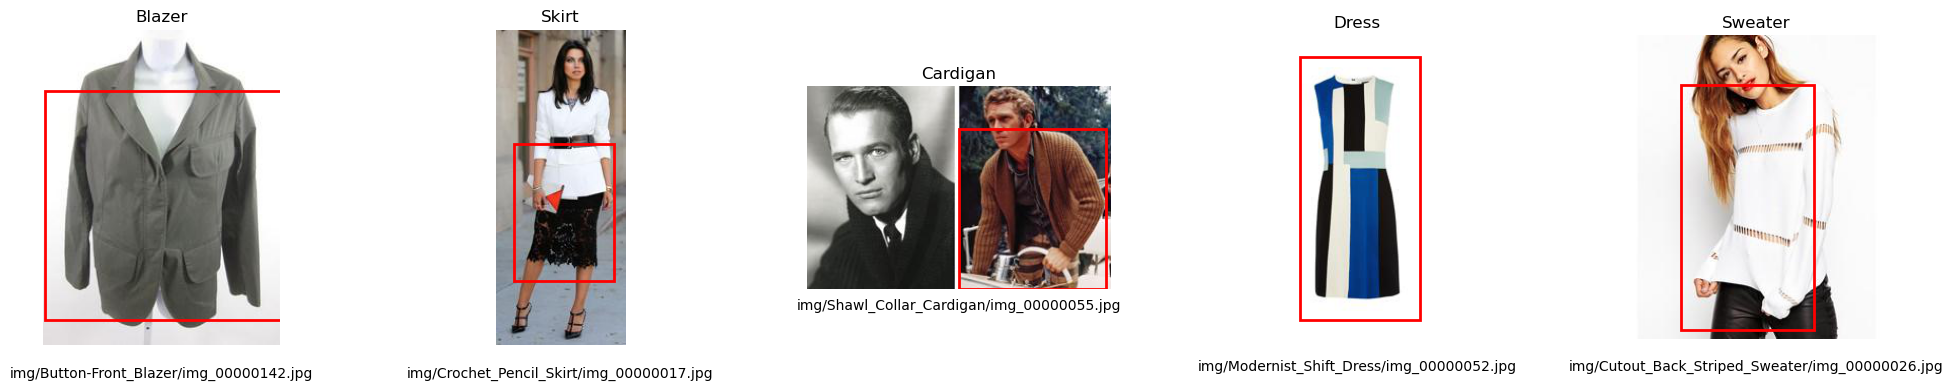

In [481]:
merged_data = pd.merge(bbox_df, img_category_df, on='image_name')
merged_data = pd.merge(merged_data, category_df, on='category_id')

samples = merged_data.sample(5)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, (_, row) in enumerate(samples.iterrows()):
    img_path = os.path.join("../data", row['image_name'])
    
    try:
        img = Image.open(img_path)
        
        axes[i].imshow(img)
        
        # Draw bounding box
        bbox = [row['x_1'], row['y_1'], row['x_2'], row['y_2']]
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                             fill=False, edgecolor='red', linewidth=2)
        axes[i].add_patch(rect)
        
        # Add category label
        axes[i].set_title(f"{row['category_name']}")
        axes[i].axis('off')
        axes[i].text(0.5, -0.1, row['image_name'], transform=axes[i].transAxes, ha='center')

        
    except Exception as e:
        axes[i].text(0.5, 0.5, f"Error loading image:\n{str(e)}", 
                     horizontalalignment='center', verticalalignment='center',
                     transform=axes[i].transAxes)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# 2. Data Organization and Cleaning

In [382]:
def combine_dataframes(bbox_df, img_category_df, category_df, eval_df, attr_img_df):
    
    main_df = pd.merge(bbox_df, img_category_df, on='image_name', how='inner')
    main_df = pd.merge(main_df, category_df, on='category_id', how='inner')
    main_df = pd.merge(main_df, eval_df, on='image_name', how='inner')
    main_df = pd.merge(main_df, attr_img_df, on='image_name', how='inner')
    
    # Add absolute image path column
    main_df['absolute_path'] = main_df['image_name'].apply(lambda x: os.path.join("../data", x))
    
    # Count the number of attributes per image
    main_df['num_attributes'] = main_df['positive_attributes'].apply(len)

    return main_df

In [383]:
main_df = combine_dataframes(bbox_df, img_category_df, category_df, eval_df, attr_img_df)
main_df.head()

,image_name,x_1,y_1,x_2,y_2,width,height,area,category_id,category_name,category_type,category_type_name,eval_status,positive_attributes,absolute_path,num_attributes
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273,160,194,31040,3,Blouse,1,upper-body,train,"[717, 818]",../data/img/Sheer_Pleated-Front_Blouse/img_000...,2
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161,88,102,8976,3,Blouse,1,upper-body,train,"[717, 818]",../data/img/Sheer_Pleated-Front_Blouse/img_000...,2
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200,91,135,12285,3,Blouse,1,upper-body,val,"[141, 717, 837, 956]",../data/img/Sheer_Pleated-Front_Blouse/img_000...,4
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182,116,120,13920,3,Blouse,1,upper-body,train,[716],../data/img/Sheer_Pleated-Front_Blouse/img_000...,1
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262,120,174,20880,3,Blouse,1,upper-body,test,"[349, 405, 717, 810]",../data/img/Sheer_Pleated-Front_Blouse/img_000...,4


In [384]:
# Check for missing values
missing_vals = main_df.isnull().sum()
print(missing_vals[missing_vals > 0] if len(missing_vals[missing_vals > 0]) > 0 else "No missing values")

No missing values


In [385]:
# Duplicate images
duplicate_images = main_df.duplicated(subset=['image_name']).sum()
print(f"\nNumber of duplicate images: {duplicate_images}")


Number of duplicate images: 0
